# eXplainable AI (XAI): Explain your model with [SHAP](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) and [M3d-Cam](https://github.com/MECLabTUDA/M3d-Cam)<br>

1. Mount dataset and get label dataset
2. SHAP 
3. Grad-Cam++ 

In [ ]:
#!pip install shap
#!pip install torchxrayvision
#!pip install medcam

In [72]:
# Connect to workspace
from azureml.core import Workspace
# Load workspace from config file
# The workspace is the top-level resource for Azure Machine Learning, 
# providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning.
# Documentation: https://docs.microsoft.com/en-us/azure/machine-learning/concept-workspace
ws = Workspace.from_config(path='../')
print("Workspace:",ws.name)

Workspace: rsna2021amldemo


### 1. Mount dataset and get label dataset

In [73]:
from azureml.core import Dataset
from azureml.contrib.dataset import FileHandlingOption
import pandas as pd
import os
os.environ["RSLEX_DIRECT_VOLUME_MOUNT"] = "true" # IMPORTANT for performance

# Mount and use files
dataset = Dataset.get_by_name(ws, name="padchest")
mount = dataset.mount()
mount.start()
print(mount.mount_point)

pc_csv_file = os.path.join(mount.mount_point, "PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv")
pc_df = pd.read_csv(pc_csv_file, low_memory=False, index_col=0)

/tmp/tmpg2nrni30


### Visualize a random image

file: /tmp/tmpg2nrni30/png/0/199932188422938481238592789979586445399_5tsy8k.png
exists?:  True
['aortic elongation', 'cardiomegaly']


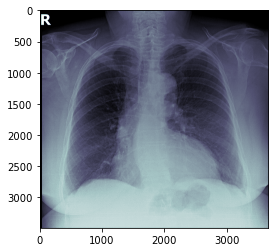

In [95]:
from skimage.io import imread
import matplotlib.pylab as plt
import random

random_index = random.randint(1,1000)
pc_df.loc[random_index,"ImageID"]
test_file = str(mount.mount_point) + os.sep + 'png' + os.sep + str(pc_df.loc[random_index,"ImageDir"]) + os.sep + pc_df.loc[random_index,  "ImageID"]
print("file:", test_file)
print(f"exists?: ", os.path.exists(test_file))

img = imread(test_file)
plt.imshow(img, cmap=plt.cm.bone)
print(pc_df.loc[random_index,"Labels"])

### 2. SHAP Explainer
Download registered model and set up image data loader from mounted directory

In [97]:
import shap
import torch
import torchvision, torchvision.transforms
import torchxrayvision as xrv
import numpy as np
from azureml.core.model import Model
import sys

sys.path.insert(0,r'./../3.Build a model/trainingscripts')
from padchest_dataset import PC_Dataset_Custom

# Set resolution according to Densenet
transforms = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])

# Get register model
model_ws = Model(ws, 'padchest', version=7) # NOTE: you may have a different version here

model_name = './pc-densenet-densenet-best.pt'
if not os.path.exists(model_name):
    model_ws.download(exist_ok=True)

model = torch.load('pc-densenet-densenet-best.pt')

#Select CUDA or CPU support
device = 'cuda'
# device = 'cpu'
model.to(device)

transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),
                                            xrv.datasets.XRayResizer(224, engine="cv2")])

imgpath = mount.mount_point + os.sep + 'png'
dataset = PC_Dataset_Custom(
    imgpath=imgpath,
    csvpath=pc_csv_file,
    transform=transform, unique_patients=True, views=["PA"],flat_dir=False)

Setting XRayResizer engine to cv2 could increase performance.
Setting XRayResizer engine to cv2 could increase performance.
['Air Trapping', 'Aortic Atheromatosis', 'Aortic Elongation', 'Atelectasis', 'Bronchiectasis', 'Cardiomegaly', 'Consolidation', 'Costophrenic Angle Blunting', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Flattened Diaphragm', 'Fracture', 'Granuloma', 'Hemidiaphragm Elevation', 'Hernia', 'Hilar Enlargement', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax', 'Scoliosis', 'Tuberculosis']


In [24]:
# Get a uniform randomly sampled batch from the dataset. 
# Use it to initialize the SHAP explainer

from torch.utils.data import DataLoader
batch_training = DataLoader(dataset, batch_size=40, shuffle=True)
it = iter(batch_training)
batch_init = next(it)
batch_training_images = batch_init["img"].float().to(device)
e = shap.GradientExplainer((model, model.features.denseblock3.denselayer24.conv2), batch_training_images)

In [26]:
# Explains a model using expected gradients from a testing sample

batch_testing = DataLoader(dataset, batch_size=10, shuffle=True)
it = iter(batch_testing)
batch_testing = next(it)
batch_testing_images = batch_testing["img"].float().to(device)

def visualize_shap(images):
    shap_values, indexes = e.shap_values(images.reshape((1,1,224,224)), ranked_outputs=3, nsamples=200)
    # plot the explanations
    shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
    original_image = images.reshape((1,224,224,1)).detach().cpu().numpy()
    shap.image_plot(shap_values, original_image, show=True)


running shap... done


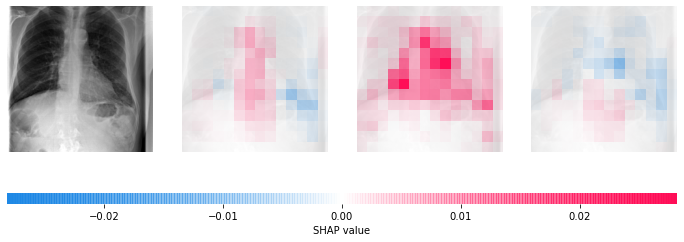

In [27]:
# Visualize the predicted top three classes and SHAP coefficients

visualize_shap(batch_testing_images[0].float().to(device))

running shap... done


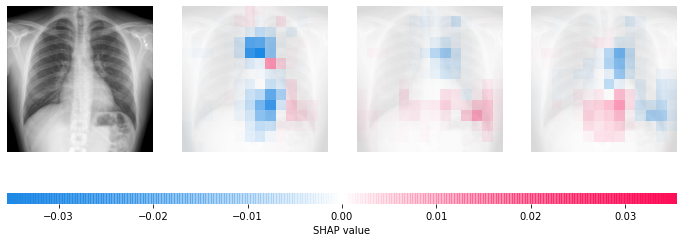

In [29]:
visualize_shap(batch_testing_images[1].float().to(device))

running shap... done


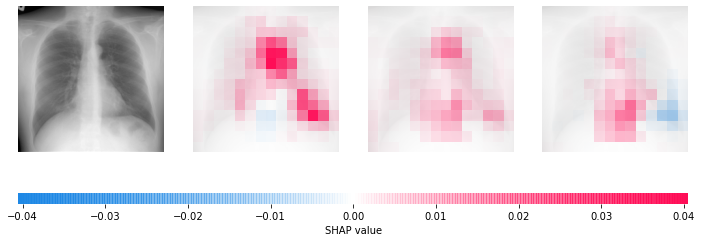

In [30]:
visualize_shap(batch_testing_images[2].float().to(device))

### 3. Explain model using Grad-Cam++


In [71]:
# Inject model into Medcam explainer and use Grad-Cam++ as core model
from medcam import medcam
model_medcam = medcam.inject(model, output_dir="attention_maps", save_maps=True, return_attention=True, label='best',backend='gcampp')

def show_medcam_image(img_raw, img_attention ):
    img_attention = img_attention.reshape((224, 224))
    img_raw =img_raw.reshape((224, 224)).detach().cpu().numpy()
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(img_raw,cmap="Greys_r")
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(img_raw,cmap="Greys_r")    
    plt.imshow(img_attention, alpha=0.4,cmap='Reds')

### Visualize Grad-Cam++

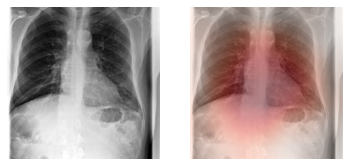

In [68]:
__ , img_attention = model_medcam( batch_testing_images[0].float().to(device).reshape((1,1,224,224)) )
img_attention = img_attention.reshape((224, 224)).detach().cpu().numpy()
show_medcam_image(batch_testing_images[0], img_attention )

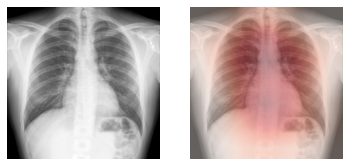

In [69]:
__ , img_attention = model_medcam( batch_testing_images[1].float().to(device).reshape((1,1,224,224)) )
img_attention = img_attention.reshape((224, 224)).detach().cpu().numpy()
show_medcam_image(batch_testing_images[1], img_attention )

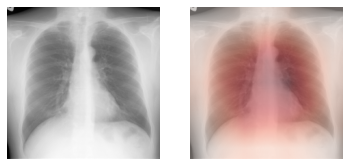

In [70]:
__ , img_attention = model_medcam( batch_testing_images[2].float().to(device).reshape((1,1,224,224)) )
img_attention = img_attention.reshape((224, 224)).detach().cpu().numpy()
show_medcam_image(batch_testing_images[2], img_attention )